In [66]:
import yfinance as yf
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Check if the data is already downloaded
DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    # Read the data if it is already downloaded
    with open(DATA_PATH) as f:
        msft_hist = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period = "max")

    # Save the data in a json file
    msft_hist.to_json(DATA_PATH)



In [67]:
# Show the first 5 rows of the data
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13 05:00:00,0.055241,0.063365,0.055241,0.060657,1031788800,0.0,0.0
1986-03-14 05:00:00,0.060657,0.063907,0.060657,0.062823,308160000,0.0,0.0
1986-03-17 05:00:00,0.062823,0.064448,0.062823,0.063907,133171200,0.0,0.0
1986-03-18 05:00:00,0.063907,0.064448,0.061740,0.062281,67766400,0.0,0.0
1986-03-19 05:00:00,0.062281,0.062823,0.060657,0.061198,47894400,0.0,0.0


<Axes: >

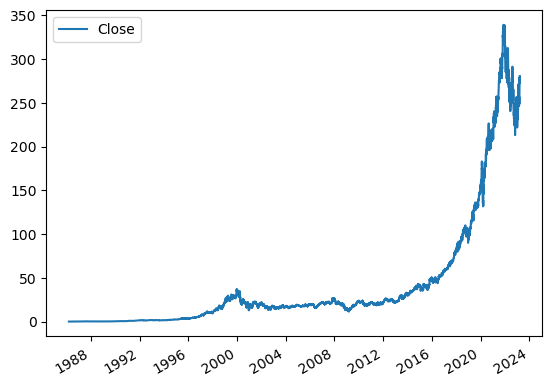

In [68]:
# Plot the stock prices
msft_hist.plot.line(y="Close", use_index=True)

In [69]:
# Save the actual closing data
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close': 'Actual_Close'})

# Save in target if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [70]:
data.head()

,Actual_Close,Target
1986-03-13 05:00:00,0.060657,NaN
1986-03-14 05:00:00,0.062823,1.0
1986-03-17 05:00:00,0.063907,1.0
1986-03-18 05:00:00,0.062281,0.0
1986-03-19 05:00:00,0.061198,0.0


In [71]:
# shift stock prices one day, to predict tomorrow's prices whith today's prices
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [72]:
msft_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14 05:00:00,0.055241,0.063365,0.055241,0.060657,1.031789e+09,0.0,0.0
1986-03-17 05:00:00,0.060657,0.063907,0.060657,0.062823,3.081600e+08,0.0,0.0
1986-03-18 05:00:00,0.062823,0.064448,0.062823,0.063907,1.331712e+08,0.0,0.0
1986-03-19 05:00:00,0.063907,0.064448,0.061740,0.062281,6.776640e+07,0.0,0.0


In [73]:
# Create training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

In [74]:
data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
1986-03-14 05:00:00,0.062823,1.0,0.060657,1.031789e+09,0.055241,0.063365,0.055241
1986-03-17 05:00:00,0.063907,1.0,0.062823,3.081600e+08,0.060657,0.063907,0.060657
1986-03-18 05:00:00,0.062281,0.0,0.063907,1.331712e+08,0.062823,0.064448,0.062823
1986-03-19 05:00:00,0.061198,0.0,0.062281,6.776640e+07,0.063907,0.064448,0.061740
1986-03-20 05:00:00,0.059574,0.0,0.061198,4.789440e+07,0.062281,0.062823,0.060657


In [75]:
# Create a random forest classification model
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1) 


In [76]:
# Create train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])


RandomForestClassifier(min_samples_split=200, random_state=1)

In [77]:
from sklearn.metrics import precision_score

# Assess the error of predictions 
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5454545454545454

<Axes: >

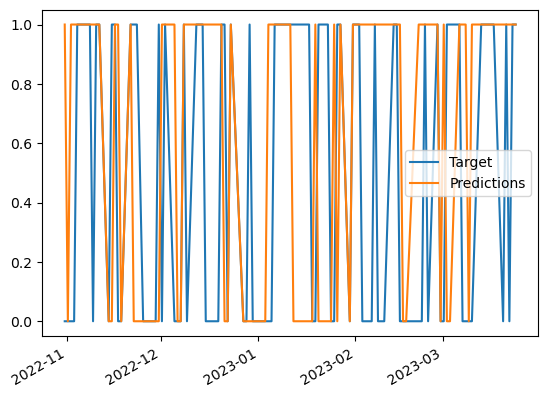

In [78]:
# Plot Target and Target prediction
combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)
combined.plot()

In [79]:
# Predict using the raw probabilities and decreasing false positives to improve precision
preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index=test.index)
preds[preds > .6] = 1
preds[preds <= .6] = 0

# Assest the error of the predictions
precision_score(test["Target"], preds)


0.75

In [81]:
# Backtesting on the data
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []

    #Loop over the dataset
    for i in range(start, data.shape[0], step):
        
        # Split data into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds <= .6] = 0

        #Combine predictions and test values
        combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis =1)

        predictions.append(combined)

    return pd.concat(predictions)




In [85]:
predictions = backtest(data, model, predictors)
# Count Ups and Downs on the stock price predictions
predictions["Predictions"].value_counts()

0.0    7591
1.0     742
Name: Predictions, dtype: int64